In [233]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

import imblearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer

import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder


import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.datasets import make_regression


## load dataset

In [248]:
data = pd.read_csv("InsNova_data_2023_train.csv", index_col='id')


In [249]:
data.head()

,veh_value,exposure,veh_body,veh_age,gender,area,agecat,engine_type,max_power,driving_history_score,...,marital_status,e_bill,time_of_week_driven,time_driven,trm_len,credit_score,high_education_ind,clm,numclaims,claimcst0
id,,,,,,,,,,,,,,,,,,,,,
1,0.77,0.444504,SEDAN,4,M,D,3,petrol,147,67.0,...,S,1,weekday,6pm - 12am,6,640.448137,1.0,0,0,0.0
2,4.45,0.562183,STNWG,1,M,A,3,petrol,158,76.0,...,S,1,weekday,6am - 12pm,12,683.749691,0.0,0,0,0.0
3,4.90,0.465244,STNWG,1,F,A,3,petrol,159,58.0,...,M,1,weekday,6pm - 12am,6,653.656117,1.0,0,0,0.0
4,0.48,0.271039,PANVN,4,M,A,4,petrol,80,72.0,...,S,1,weekday,12pm - 6pm,12,642.574671,0.0,0,0,0.0
5,0.85,0.141624,SEDAN,4,F,A,5,petrol,126,91.0,...,S,0,weekday,6am - 12pm,6,647.175035,0.0,0,0,0.0


In [251]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22619 entries, 1 to 22619
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   veh_value              22619 non-null  float64
 1   exposure               22619 non-null  float64
 2   veh_body               22619 non-null  object 
 3   veh_age                22619 non-null  int64  
 4   gender                 22619 non-null  object 
 5   area                   22619 non-null  object 
 6   agecat                 22619 non-null  int64  
 7   engine_type            22619 non-null  object 
 8   max_power              22619 non-null  int64  
 9   driving_history_score  22619 non-null  float64
 10  veh_color              22619 non-null  object 
 11  marital_status         22619 non-null  object 
 12  e_bill                 22619 non-null  int64  
 13  time_of_week_driven    22619 non-null  object 
 14  time_driven            22619 non-null  object 
 15  tr

In [ ]:
# check for null values
data.isnull().sum()

veh_value                0
exposure                 0
veh_body                 0
veh_age                  0
gender                   0
area                     0
agecat                   0
engine_type              0
max_power                0
driving_history_score    0
veh_color                0
marital_status           0
e_bill                   0
time_of_week_driven      0
time_driven              0
trm_len                  0
credit_score             0
high_education_ind       0
clm                      0
numclaims                0
claimcst0                0
dtype: int64

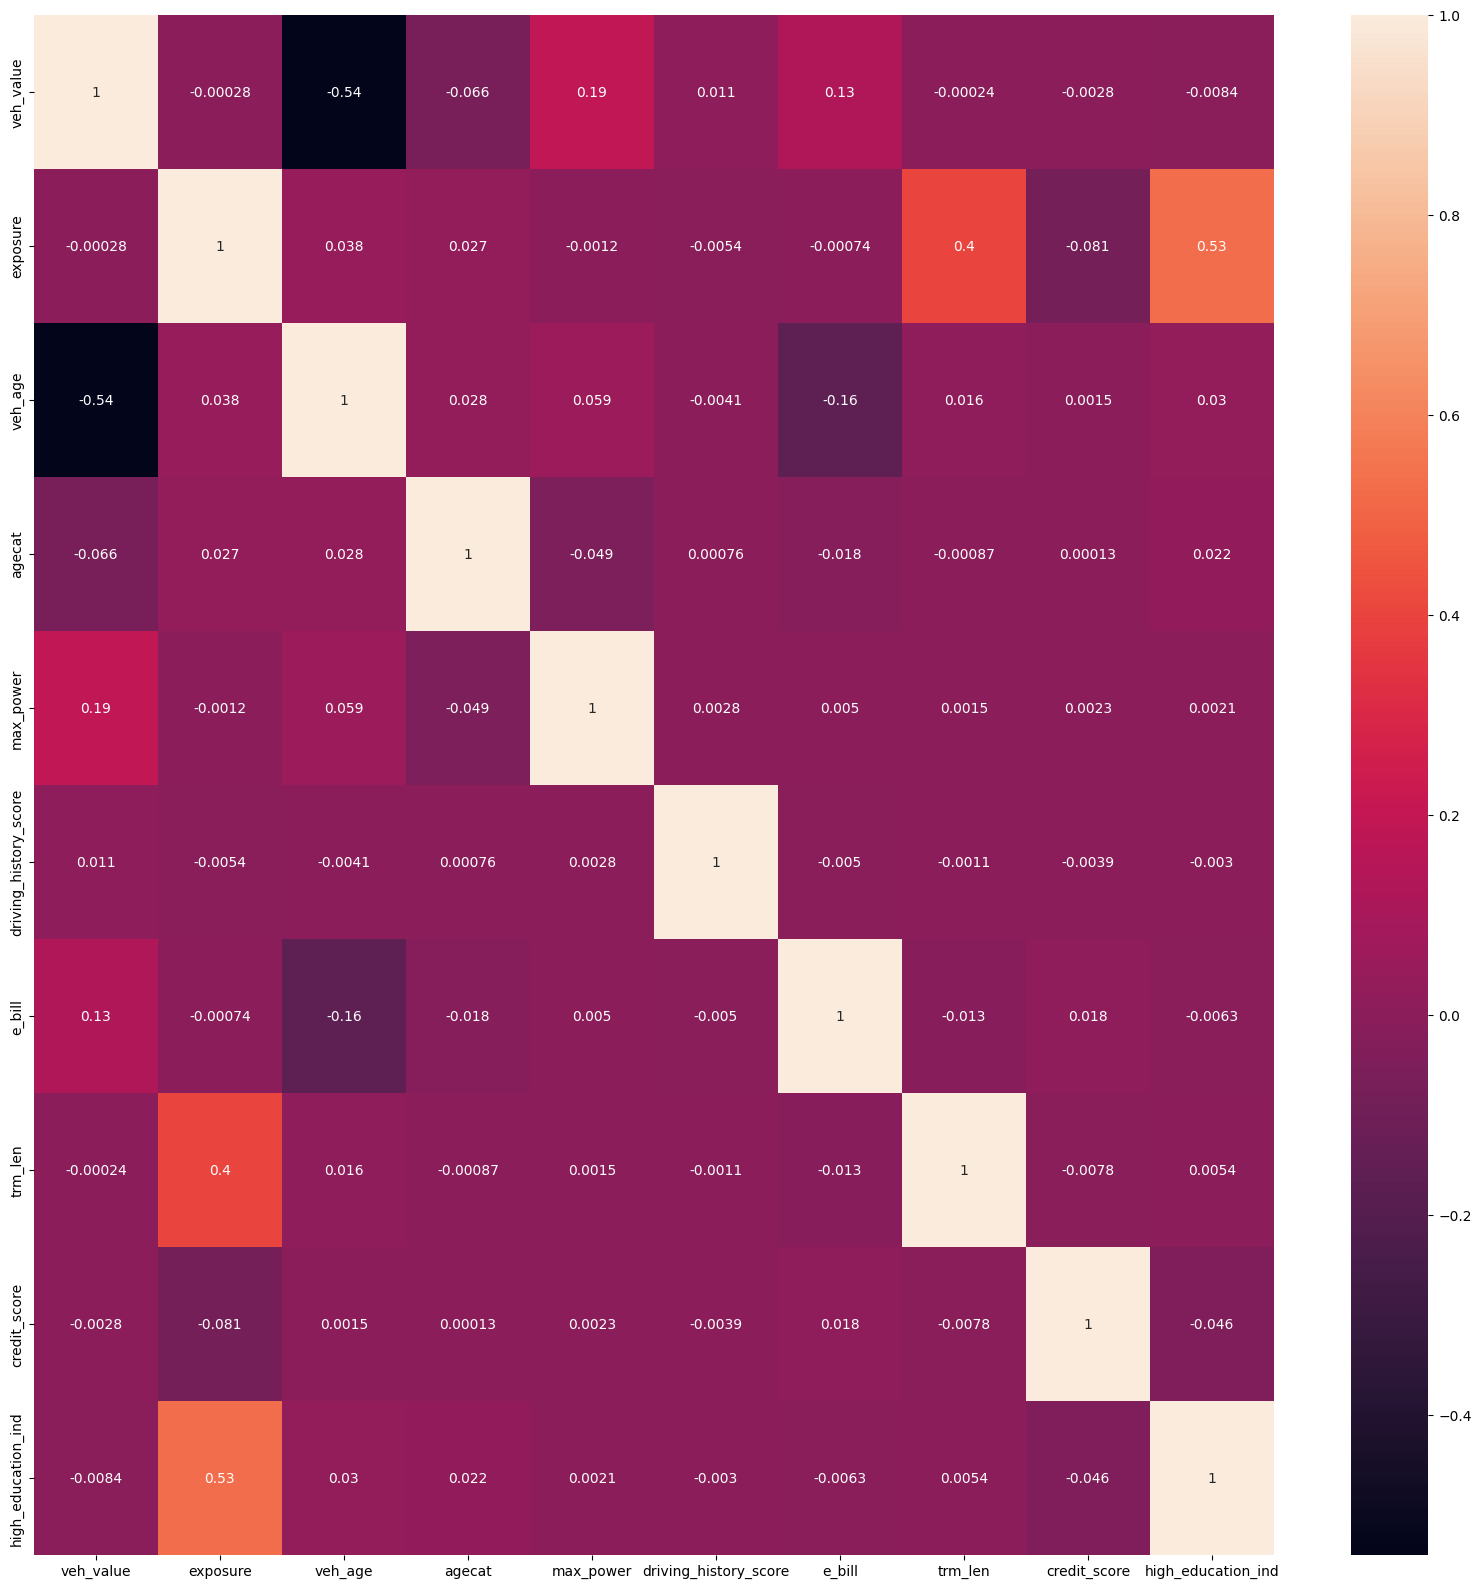

In [144]:
plt.figure(figsize=(20,20))
newdata = data.drop(['clm', 'numclaims', 'claimcst0'], axis=1)
sns.heatmap(newdata.corr(), annot=True)
plt.show()

## Handling Categorical Features and Transforming Integer Features

In [347]:
data["claimcst0"] = np.log1p(data["claimcst0"])

In [252]:
def addlogs(res, cols):
    """ Log transform feature list"""
    for c in cols:  # Iterate over the list of column names in 'cols'
        res[c] = np.log(1.01 + res[c])  # Log-transform the values of the specified column 'c' in-place

        # Rename the column to indicate that it has been log-transformed
        res.rename(columns={c: c + '_log'}, inplace=True)
    return res  # Return the modified DataFrame 'res' with log-transformed column values and updated column names


In [253]:
loglist = ['max_power', 'driving_history_score']

data = addlogs(data, loglist)

In [255]:
data["high_education_ind"] = (data["high_education_ind"]).astype(int)

In [256]:
def transform_to_object(lis, x):
    for i in lis:
        x[lis] = x[lis].astype(str)

In [257]:
transform_to_object(['veh_age', 'agecat', 'e_bill', 'trm_len', 'high_education_ind'], data)

In [258]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22619 entries, 1 to 22619
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   veh_value                  22619 non-null  float64
 1   exposure                   22619 non-null  float64
 2   veh_body                   22619 non-null  object 
 3   veh_age                    22619 non-null  object 
 4   gender                     22619 non-null  object 
 5   area                       22619 non-null  object 
 6   agecat                     22619 non-null  object 
 7   engine_type                22619 non-null  object 
 8   max_power_log              22619 non-null  float64
 9   driving_history_score_log  22619 non-null  float64
 10  veh_color                  22619 non-null  object 
 11  marital_status             22619 non-null  object 
 12  e_bill                     22619 non-null  object 
 13  time_of_week_driven        22619 non-null  obj

In [259]:
def encoder(x):
    label_encoder = LabelEncoder()
    for column in x.columns:
        if x[column].dtype == 'object':
            x[column] = label_encoder.fit_transform(x[column])

In [260]:
encoder(data)

## Respose and Target variable

In [348]:
data1 = data.drop(['claimcst0'], axis=1)
Y = data['claimcst0']

In [262]:
# check length of 1's and 0's
one = np.where(Y > 0)
zero = np.where(Y == 0)
len(one[0]), len(zero[0])

(1542, 21077)

## Train test split

In [349]:
x_train, x_test, y_train, y_test = train_test_split(data1, Y, test_size=0.20, random_state=5400)

In [266]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((18095, 20), (4524, 20), (18095,), (4524,))

In [267]:
x_train

,veh_value,exposure,veh_body,veh_age,gender,area,agecat,engine_type,max_power_log,driving_history_score_log,veh_color,marital_status,e_bill,time_of_week_driven,time_driven,trm_len,credit_score,high_education_ind,clm,numclaims
id,,,,,,,,,,,,,,,,,,,,
10880,1.85,0.671002,9,1,0,2,3,3,5.231162,4.111038,3,0,1,0,2,0,643.644607,0,0,0
10491,1.62,0.104164,3,1,0,2,2,3,4.691440,4.025530,7,0,1,1,1,0,640.499738,0,0,0
12115,1.30,0.113619,7,3,0,0,5,0,4.127296,4.394573,7,1,1,0,2,1,684.780542,0,0,0
6519,3.13,0.672797,3,1,1,0,1,3,4.920054,4.143293,0,0,1,0,1,0,688.258624,0,0,0
7073,2.49,0.047891,10,2,0,3,1,3,4.644487,4.382152,2,1,1,0,1,0,645.947642,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19513,0.99,0.630432,9,3,1,2,2,3,5.257547,4.406841,7,1,0,0,2,0,665.220234,0,0,0
16501,1.75,0.326757,9,1,0,5,1,2,4.934546,4.406841,7,1,0,0,2,0,643.253099,0,0,0
6894,1.68,0.148888,6,3,0,2,1,3,5.147553,4.406841,3,0,0,0,2,0,650.467718,0,0,0


In [268]:
x_train_clm = x_train.iloc[:, :-2]

In [269]:
y_train_clm = x_train.iloc[:, -2]

In [270]:
x_train_numclm = x_train.iloc[:, :-1]

In [271]:
y_train_numclm = x_train.iloc[:, -1]

In [272]:
x_test_clm = x_test.iloc[:, :-2]

In [273]:
x_test_numclm = x_test.iloc[:, :-1]

In [274]:
y_test_clm = x_test.iloc[:, -2]

In [275]:
y_test_numclm = x_test.iloc[:, -1]

## 3. Random under-sampling with imblearn

In [276]:
df_train = pd.concat([x_train_clm, y_train_clm], axis=1)
majority_class = df_train[df_train['clm'] == 0]
minority_class = df_train[df_train['clm'] == 1]
majority_class.shape, minority_class.shape
majority_class_undersampled = resample(majority_class, replace=True, n_samples=15000, random_state=42)
minority_class_oversampled = resample(minority_class, replace=True, n_samples=5000, random_state=42)
minority_class_oversampled.shape, majority_class_undersampled.shape
undersampled_df = pd.concat([minority_class_oversampled, majority_class_undersampled])
y_train_clm = undersampled_df["clm"]
undersampled_df.drop(["clm"], axis=1, inplace=True)
x_train_clm = undersampled_df

In [277]:
rfc = RandomForestClassifier(max_depth= 5,
                             max_leaf_nodes=5, 
                             class_weight="balanced",
                             random_state=5400)

In [278]:
# fit the predictor and target
rfc.fit(x_train_clm, y_train_clm)

# predict
rfc_predict = rfc.predict(x_test_clm)

In [279]:
# check performance

print('ROCAUC score:',roc_auc_score(y_test_clm, rfc_predict))
print('Accuracy score:',accuracy_score(y_test_clm, rfc_predict))
print('F1 score:',f1_score(y_test_clm, rfc_predict))

ROCAUC score: 0.6124208901466426
Accuracy score: 0.4995579133510168
F1 score: 0.1639586410635155


In [280]:
confusion_matrix(y_test_clm, rfc_predict)

array([[2038, 2187],
       [  77,  222]])

## Numclaims

In [281]:
# x_test['Pred_clm'] = rfc_predict
# x_train = pd.concat([X_train, y_train], axis=1)
# data1 = data.drop(['numclaims', 'claimcst0'], axis=1)

In [282]:
df_train = pd.concat([x_train_numclm, y_train_numclm], axis=1)
majority_class = df_train[df_train['numclaims'] == 0]
minority_class_1 = df_train[df_train['numclaims'] == 1]
minority_class_2 = df_train[df_train['numclaims'] == 2]
minority_class_3 = df_train[df_train['numclaims'] == 3]
majority_class.shape, minority_class_1.shape, minority_class_2.shape, minority_class_3.shape
majority_class_undersampled = resample(majority_class, replace=True, n_samples=10000, random_state=42)
minority_class1_oversampled = resample(minority_class_1, replace=True, n_samples=5000, random_state=42)
minority_class2_oversampled = resample(minority_class_2, replace=True, n_samples=500, random_state=42)
minority_class3_oversampled = resample(minority_class_3, replace=True, n_samples=500, random_state=42)
undersampled_df = pd.concat([majority_class_undersampled, minority_class1_oversampled, minority_class2_oversampled, minority_class3_oversampled], axis=0)
y_train_numclm = undersampled_df["numclaims"]
undersampled_df.drop(["numclaims"], axis=1, inplace=True)
x_train_numclm = undersampled_df

In [283]:
# Train XGBoost model
model = xgb.XGBRegressor(tree_method="hist",
                         eval_metric = mean_squared_error)
model.fit(x_train_numclm, y_train_numclm)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function mean_squared_error at 0x7f70a46939c0>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [284]:
pred_xgb = model.predict(x_test_numclm)
model.eval_metric(y_test_numclm, pred_xgb)

0.007970748635725748

## ClaimCost0

In [285]:
df_train = pd.concat([x_train, y_train], axis=1)
majority_class = df_train[df_train['claimcst0'] == 0]
minority_class = df_train[df_train['claimcst0'] > 0]
majority_class.shape, minority_class.shape
majority_class_undersampled = resample(majority_class, replace=True, n_samples=15000, random_state=42)
minority_class_oversampled = resample(minority_class, replace=True, n_samples=5000, random_state=42)
minority_class_oversampled.shape, majority_class_undersampled.shape
undersampled_df = pd.concat([minority_class_oversampled, majority_class_undersampled])
y_train = undersampled_df["claimcst0"]
undersampled_df.drop(["claimcst0"], axis=1, inplace=True)
x_train = undersampled_df

In [215]:
def calculate_gini_index(yTarget, yPred):
    # Combine the target values and predicted values into a 2D array
    combined_data = np.column_stack((yTarget, yPred))

    # Sort the array based on predicted values
    sorted_data = combined_data[combined_data[:, 1].argsort()]

    # Calculate cumulative sums of the target values
    cumsum_target = np.cumsum(sorted_data[:, 0])

    # Calculate Gini index components
    numerator = np.sum(sorted_data[:, 0] * sorted_data[:, 1]) / np.sum(sorted_data[:, 0])
    denominator = np.sum(cumsum_target) / len(yTarget)

    # Calculate Gini index
    gini_index = (numerator - denominator) / (denominator - np.sum((len(yTarget) - np.arange(1, len(yTarget) + 1)) / len(yTarget)))

    return gini_index


In [351]:
# Define your XGBoost regressor
xgb_regressor = xgb.XGBRegressor(booster='gbtree', learning_rate = 0.05, min_child_weight = 2, 
                            max_leaves = 5, max_bin=5)

# Define the number of folds for cross-validation
num_folds = 10

# Create a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)



# Iterate through each fold of the cross-validation
for train_index, test_index in kf.split(data1):
    # Split the data into training and validation sets
    X_train, X_val = data1.iloc[train_index], data1.iloc[test_index]
    y_train, y_val = Y.iloc[train_index], Y.iloc[test_index]
    

    # Train the XGBoost regressor on the resampled data
    xgb_regressor.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = xgb_regressor.predict(X_val)

    # Evaluate the model using the Gini index
    gini_score = calculate_gini_index(y_val, y_pred)
    print("Validation Gini Index:", gini_score)


Validation Gini Index: 0.027754664339756416
Validation Gini Index: 0.02997964986560077
Validation Gini Index: 0.03328243535800832
Validation Gini Index: 0.025526787206197287
Validation Gini Index: 0.02640199354587681
Validation Gini Index: 0.02334097939440984
Validation Gini Index: 0.02698020773598723
Validation Gini Index: 0.02788357691700635
Validation Gini Index: 0.022045253183844624
Validation Gini Index: 0.0264769972030815


## Inference

In [295]:
Validation_data = pd.read_csv("InsNova_data_2023_vh.csv", index_col='id')

In [296]:
Validation_data

,veh_value,exposure,veh_body,veh_age,gender,area,agecat,engine_type,max_power,driving_history_score,veh_color,marital_status,e_bill,time_of_week_driven,time_driven,trm_len,credit_score,high_education_ind
id,,,,,,,,,,,,,,,,,,
1,3.40,0.076279,STNWG,2,M,B,4,petrol,174,83,black,S,1,weekday,6pm - 12am,6,648.247594,0
2,2.55,0.093443,STNWG,2,F,A,3,petrol,181,65,yellow,M,0,weekday,12am - 6 am,12,637.752677,0
3,3.04,0.157762,STNWG,2,F,E,4,petrol,136,64,white,S,1,weekday,12pm - 6pm,12,661.483786,0
4,2.05,0.560735,MIBUS,4,M,C,6,dissel,164,82,gray,M,1,weekday,6am - 12pm,12,647.846365,0
5,1.93,0.258275,HBACK,2,M,C,4,dissel,89,48,black,S,0,weekday,6am - 12pm,12,640.257550,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22616,1.85,0.084422,UTE,3,M,C,2,petrol,252,99,yellow,M,1,weekday,12pm - 6pm,12,642.202480,0
22617,1.36,0.054091,HBACK,1,F,C,2,petrol,159,69,red,M,1,weekday,6pm - 12am,6,657.114629,0
22618,1.45,0.500351,SEDAN,3,M,B,2,petrol,190,99,white,M,1,weekday,12am - 6 am,12,644.610174,0


In [297]:
Validation_data = addlogs(Validation_data, loglist)

In [298]:
Validation_data["high_education_ind"] = (Validation_data["high_education_ind"]).astype(int)

In [299]:
transform_to_object(['veh_age', 'agecat', 'e_bill', 'trm_len', 'high_education_ind'], Validation_data)

In [300]:
encoder(Validation_data)

In [301]:
Validation_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22620 entries, 1 to 22620
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   veh_value                  22620 non-null  float64
 1   exposure                   22620 non-null  float64
 2   veh_body                   22620 non-null  int64  
 3   veh_age                    22620 non-null  int64  
 4   gender                     22620 non-null  int64  
 5   area                       22620 non-null  int64  
 6   agecat                     22620 non-null  int64  
 7   engine_type                22620 non-null  int64  
 8   max_power_log              22620 non-null  float64
 9   driving_history_score_log  22620 non-null  float64
 10  veh_color                  22620 non-null  int64  
 11  marital_status             22620 non-null  int64  
 12  e_bill                     22620 non-null  int64  
 13  time_of_week_driven        22620 non-null  int

## Predicting 'clm' on Validation data

In [302]:
rfc_predict_vh = rfc.predict(Validation_data)

In [315]:
# Add the NumPy array as a new column named 'C'
Validation_data['clm'] = rfc_predict_vh



,veh_value,exposure,veh_body,veh_age,gender,area,agecat,engine_type,max_power_log,driving_history_score_log,veh_color,marital_status,e_bill,time_of_week_driven,time_driven,trm_len,credit_score,high_education_ind,clm
id,,,,,,,,,,,,,,,,,,,
1,3.40,0.076279,10,1,1,1,3,3,5.164843,4.430936,0,1,1,0,3,1,648.247594,0,0
2,2.55,0.093443,10,1,0,0,2,3,5.204062,4.189806,8,0,0,0,0,0,637.752677,0,0
3,3.04,0.157762,10,1,0,4,3,3,4.920054,4.174541,7,1,1,0,1,0,661.483786,0,0
4,2.05,0.560735,6,3,1,2,5,0,5.106006,4.418961,3,0,1,0,2,0,647.846365,0,1
5,1.93,0.258275,3,1,1,2,3,0,4.499921,3.892024,0,1,0,0,2,0,640.257550,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22616,1.85,0.084422,12,2,1,2,1,3,5.533429,4.605270,8,0,1,0,1,0,642.202480,0,0
22617,1.36,0.054091,3,0,0,2,1,3,5.075236,4.248638,5,0,1,0,3,1,657.114629,0,0
22618,1.45,0.500351,9,2,1,1,1,3,5.252326,4.605270,7,0,1,0,0,0,644.610174,0,1


## Predicting 'numclaims' on Validation data

In [320]:
pred_xgb_vh = model.predict(Validation_data)

In [335]:
Validation_data['numclaims'] = abs(np.round(Validation_data.numclaims)).astype(int)

## Predicting 'claimcst0' on Validation data

In [352]:
y_pred_clmcst_vh = xgb_regressor.predict(Validation_data)

In [375]:
m = np.exp(y_pred_clmcst_vh)
m[m < 5] = 0

In [377]:
Validation_data['claimcst0'] = m

In [378]:
Validation_data

,veh_value,exposure,veh_body,veh_age,gender,area,agecat,engine_type,max_power_log,driving_history_score_log,...,marital_status,e_bill,time_of_week_driven,time_driven,trm_len,credit_score,high_education_ind,clm,numclaims,claimcst0
id,,,,,,,,,,,,,,,,,,,,,
1,3.40,0.076279,10,1,1,1,3,3,5.164843,4.430936,...,1,1,0,3,1,648.247594,0,0,0,0.000000
2,2.55,0.093443,10,1,0,0,2,3,5.204062,4.189806,...,0,0,0,0,0,637.752677,0,0,0,0.000000
3,3.04,0.157762,10,1,0,4,3,3,4.920054,4.174541,...,1,1,0,1,0,661.483786,0,0,0,0.000000
4,2.05,0.560735,6,3,1,2,5,0,5.106006,4.418961,...,0,1,0,2,0,647.846365,0,1,1,972.448364
5,1.93,0.258275,3,1,1,2,3,0,4.499921,3.892024,...,1,0,0,2,0,640.257550,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22616,1.85,0.084422,12,2,1,2,1,3,5.533429,4.605270,...,0,1,0,1,0,642.202480,0,0,0,0.000000
22617,1.36,0.054091,3,0,0,2,1,3,5.075236,4.248638,...,0,1,0,3,1,657.114629,0,0,0,0.000000
22618,1.45,0.500351,9,2,1,1,1,3,5.252326,4.605270,...,0,1,0,0,0,644.610174,0,1,1,1010.849792


In [384]:
if not os.path.isdir("2023_Travelers_Final_result"):
    os.mkdir("2023_Travelers_Final_result")

In [392]:
with open("2023_Travelers_Final_result/Hawkeyed2023.csv", "w") as fw:
    # Write the header row.
    header = "id,Predict\n"
    fw.write(header)
    print(header, end="")            # Print the header row just to check the current status.
    
    # Write the value rows.
    for idx, row in Validation_data.iterrows():
        pred = round(row.claimcst0, 2)
        
        line = "{},{}\n".format(idx, pred)
        fw.write(line)


id,Predict
